In [2]:
library(Matching)
library(plyr)
library(tidyverse)
library(stringr)
library(magrittr)
library(caret)
library(itecv)

In [3]:
models = list(
# ranger_spec = list(method = "ranger",
#                    tune_grid = expand.grid(mtry = c(3,5),
#                                            splitrule="variance",
#                                            min.node.size=5)),
gbm_spec = list(method = "gbm",
                tune_grid = expand.grid(n.trees = seq(1,501,5), 
                                        interaction.depth=3, 
                                        shrinkage = 0.2, 
                                        n.minobsinnode=3))
# enet_spec = list(method = "enet",
#                  tune_grid = expand.grid(fraction=0.5,
#                                          lambda=exp(seq(-5,2,0.5))))
# nnet_spec = list(method = "nnet",
#                  tune_grid = expand.grid(size = seq(10,30,5),
#                                          decay = exp(seq(-7,0,1))))
)

# dgp 7 shows nice discrimination b/t value and MSE methods
DGP = powers_DGPs()[[7]] 
n_folds = 10
rep = 1
n_train = 500
n_test = 1000

data_stuff = setup_data(DGP, n_train, n_test, n_folds)
estimate_stuff = data_stuff %$% get_estimates(data, models, cv_index, test_index)
# estimate_stuff = data_stuff %$% get_estimates(data, list(models[[2]]), cv_index, test_index)
error_stuff = estimate_stuff %$% get_errors(cv_estimates, test_estimates, data_stuff$aux_data)

Warning message:
: package ‘bindrcpp’ was built under R version 3.2.5

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1       20.2068             nan     0.2000    0.1122
     2       19.0784             nan     0.2000    0.4970
     3       18.4192             nan     0.2000    0.1692
     4       17.8137             nan     0.2000   -0.2273
     5       16.9535             nan     0.2000    0.0771
     6       16.3748             nan     0.2000   -0.1910
     7       15.8704             nan     0.2000    0.0576
     8       15.5269             nan     0.2000   -0.3492
     9       15.0306             nan     0.2000   -0.0709
    10       14.5575             nan     0.2000   -0.1378
    20       12.2176             nan     0.2000   -0.4509
    40        9.5827             nan     0.2000   -0.1986
    60        7.6037             nan     0.2000   -0.1905
    80        6.3055             nan     0.2000   -0.3090
   100        5.0843             nan     0.2000   -0.2034
   120        4.0289             nan     0.2000   -0.1025
   140        

Warning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vectorWarning message:
In bind_rows_(x, .id): binding character and factor vector, coercing into character vector

## plot

In [6]:
method_type = c(
    'random' = NA,
    'match_mse'= "tmse",
    'trans_mse'= "tmse",
    'trans_mse_est_prop'= "tmse",
    'match_decision' = "cost",
    'trans_decision'= "cost",
    'trans_decision_est_prop'= "cost",
    'gain' = "cost",
    'value'= "cost",
    'value_est_prop'= "cost",
    'c_benefit' = "auc",
    'qini'= "auc", 
    'value_auc'= 'auc',
    'est_te_strata' = "tmse",
    'prediction_error'= "tmse",
    'true_value' = "cost",
    "true_hte_error" = "tmse",
    "oracle" = "oracle"
) %>% map_chr(~str_wrap(.,15))

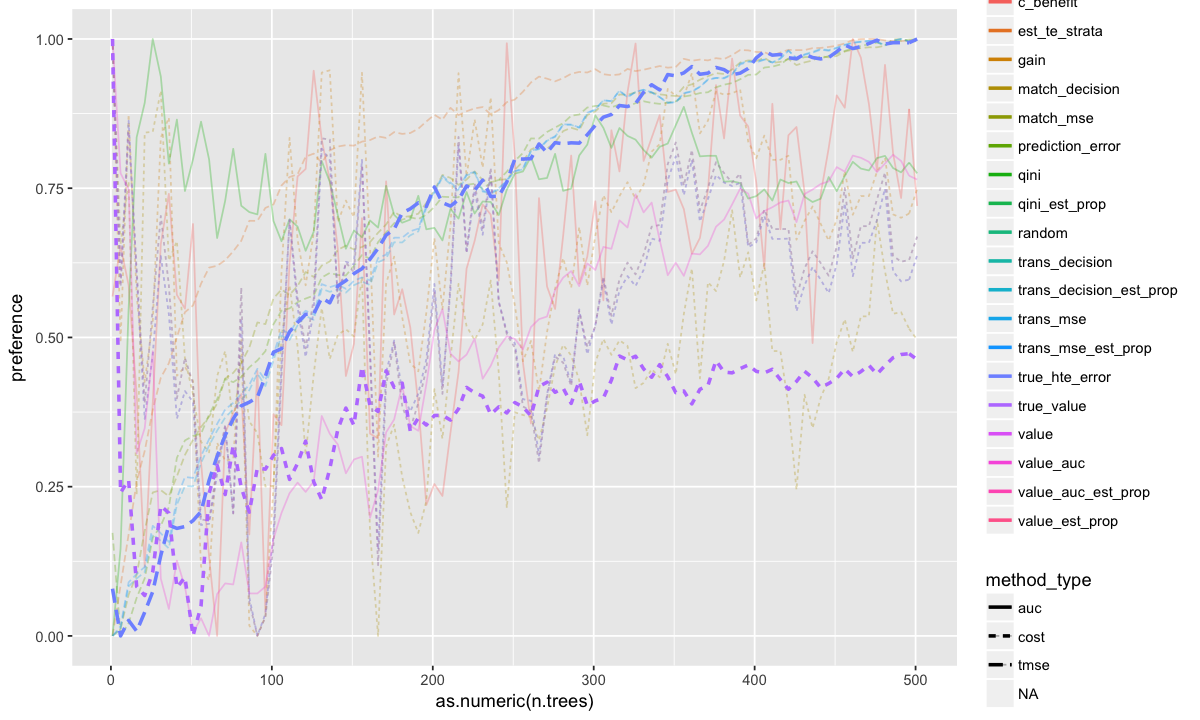

In [7]:
options(repr.plot.width=10, repr.plot.height=6)

cv_plot = error_stuff$cv_error %>%
#     filter(selection_method %in% c("gain", "qini", "value", "value_auc")) %>%
    mutate(method_type = method_type[selection_method]) %>%
    filter(str_detect(model,"^gbm")) %>%
    separate(model, c("method", names(models[[1]]$tune_grid)), sep="~") %>%
    rename(metric=selection_method) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error, na.rm=T))/(max(error, na.rm=T)-min(error, na.rm=T))) %>%
    mutate(evaluation = "cv") 

# ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
#     geom_line(aes(color=metric)) 

test_plot = error_stuff$test_error %>% 
    filter(str_detect(model,"^gbm")) %>%
    separate(model, c("method", names(models[[1]]$tune_grid)), sep="~") %>%
    gather(metric, error, true_hte_error, true_value) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error))/(max(error)-min(error))) %>%
    mutate(evaluation = "test") %>%
    mutate(method_type = method_type[metric]) 

# # ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
# #     geom_line(aes(color=metric), size=3) 

cv_plot %>% bind_rows(test_plot) %>%
ggplot(aes(x=as.numeric(n.trees), y=preference)) + 
    geom_line(data=cv_plot, aes(color=metric, linetype=method_type), alpha=0.3) + 
    geom_line(data=test_plot, aes(color=metric, linetype=method_type), size=1)

In [11]:
error_stuff$true_selection_error %>% arrange(-true_hte_error) %>% data.frame

,model,selection_method,true_hte_error,true_value
1,nnet~30~0.367879441171442,match_decision,4.694407,-1.071375
2,nnet~25~0.135335283236613,gain,4.693598,-0.991706
3,nnet~25~0.135335283236613,trans_decision,4.693598,-0.991706
4,nnet~25~0.135335283236613,value,4.693598,-0.991706
5,nnet~20~1,oracle_selector_true_value,4.686207,-1.071798
6,nnet~30~1,random,4.686001,-1.071188
7,nnet~30~0.00247875217666636,c_benefit,4.6403,-0.7019732
8,ranger~5~variance~5,est_te_strata,1.392353,-0.9842382
9,ranger~5~variance~5,match_mse,1.392353,-0.9842382
10,ranger~5~variance~5,prediction_error,1.392353,-0.9842382


In [55]:
processed_results = results %>%
    group_by(DGP, rep) %>% 
    mutate(rel_value = true_value/max(true_value, rm.na=T),
#        rel_value_opt = true_deficiency/optimal_deficiency,
       rel_increased_error = true_hte_error/min(true_hte_error, rm.na=T))

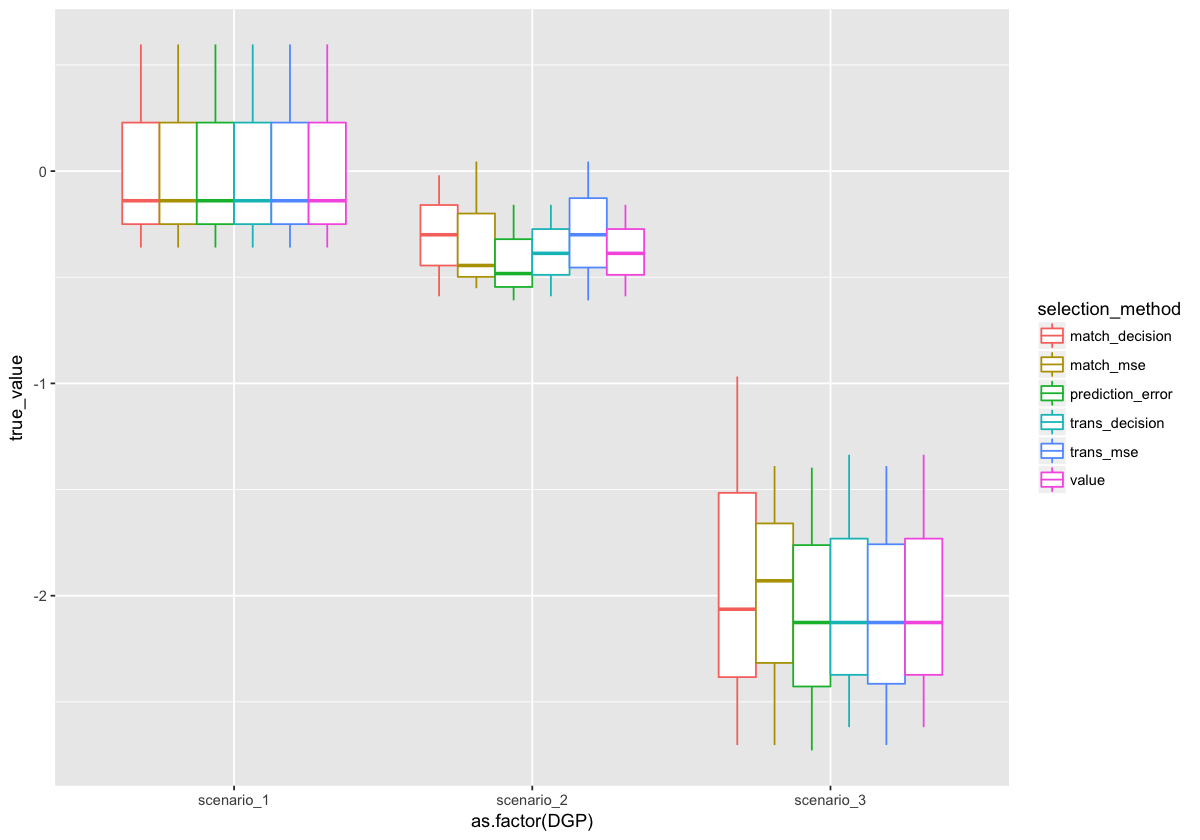

In [57]:
options(repr.plot.width=10, repr.plot.height=7)
processed_results %>%
ggplot(aes(x=as.factor(DGP), y=true_value, color=selection_method)) +
    geom_boxplot()

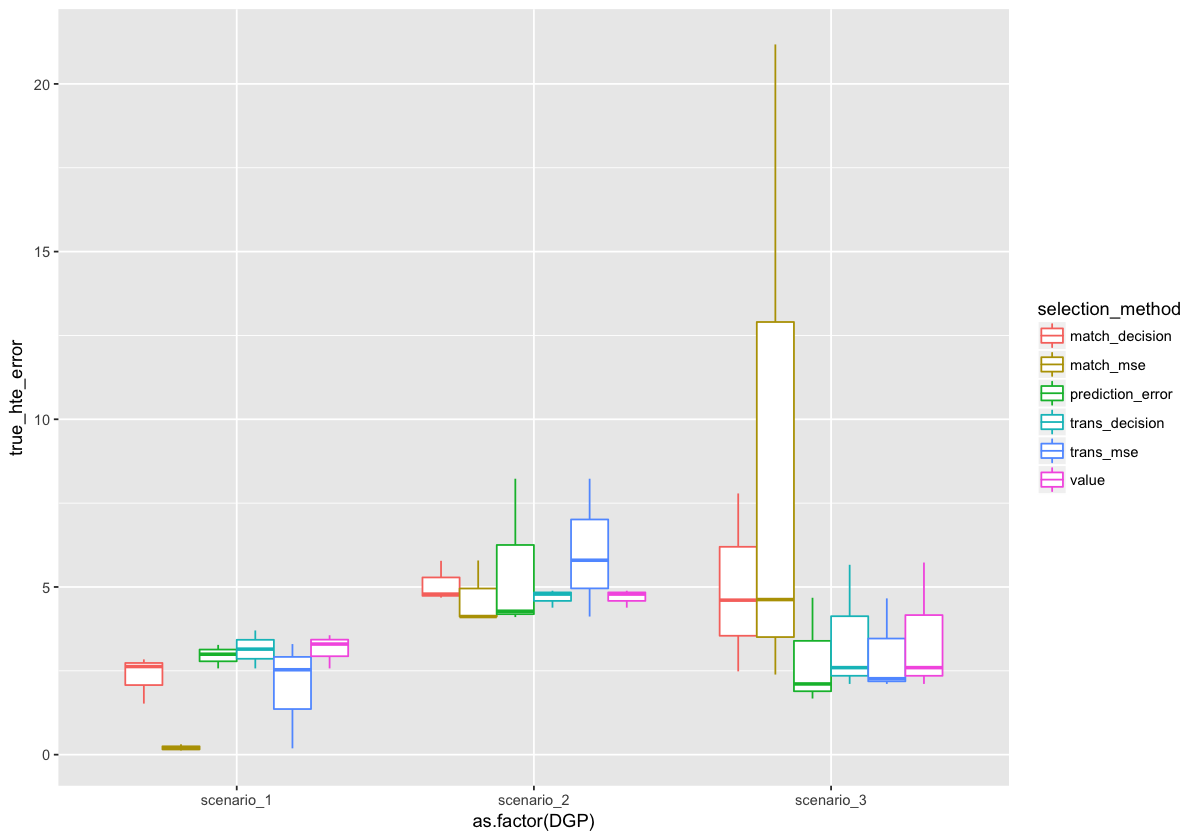

In [58]:
options(repr.plot.width=10, repr.plot.height=7)
results %>%
ggplot(aes(x=as.factor(DGP), y=true_hte_error, color=selection_method)) +
    geom_boxplot()